In [1]:
from padelpy import padeldescriptor
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
import joblib
from sklearn.metrics import r2_score
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import csv

In [2]:
df = pd.read_csv('plasmodium_targets_final_pIC50.csv')
df.head()

molecule_chembl_id                                   canonical_smiles  \
0       CHEMBL431611  Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...   
1       CHEMBL316132  Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...   
2       CHEMBL304552  Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...   
3        CHEMBL85881  Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...   
4        CHEMBL85536  Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...   

        MW    LogP  NumHDonors  NumHAcceptors  NumRotatableBonds  CarbonCount  \
0  439.621  6.0415         1.0            5.0                6.0         26.0   
1  467.675  6.8217         1.0            5.0                6.0         28.0   
2  463.599  5.9296         2.0            6.0                6.0         27.0   
3  467.675  6.8217         1.0            5.0                7.0         28.0   
4  461.627  6.0940         1.0            5.0                7.0         28.0   

   OxygenCount     pIC50  
0          3.0  8.602060  
1          3.0  8.124939  
2          4.0  8.508638  
3          3.0  8.408935  
4          3.0  8.130768

In [4]:
df2 = df[['canonical_smiles','pIC50']]
df2.to_csv('molecule.smi',sep='\t',index=False, header=False)
df2

canonical_smiles     pIC50
0     Oc1ccc2c(c1)S[C@H](C1CCCC1)[C@H](c1ccc(OCCN3CC...  8.602060
1     Oc1ccc2c(c1)S[C@H](C1CCCCCC1)[C@H](c1ccc(OCCN3...  8.124939
2     Oc1ccc([C@H]2Sc3cc(O)ccc3O[C@H]2c2ccc(OCCN3CCC...  8.508638
3     Oc1ccc2c(c1)S[C@H](CC1CCCCC1)[C@H](c1ccc(OCCN3...  8.408935
4     Oc1ccc2c(c1)S[C@H](Cc1ccccc1)[C@H](c1ccc(OCCN3...  8.130768
...                                                 ...       ...
3073  O=C(O)c1ccc2c(c1)CCCC(c1ccc(Cl)cc1Cl)=C2c1ccc(...  7.238824
3074  CC(F)(F)c1cc(Cl)ccc1-c1sc2c(ccc3[nH]ncc32)c1Oc...  7.987163
3075  CC(F)(F)c1cc(Cl)ccc1-c1sc2c(ccc3[nH]ncc32)c1Oc...  7.882729
3076  O=S(=O)(Oc1cccc2ccccc12)C1CC2OC1C(c1ccc([Se]c3...  6.508638
3077  COc1ccc(/C=C\c2cc(OC)c(OC)c(OC)c2)cc1OC(=O)N(C...  7.823909

[3078 rows x 2 columns]

In [4]:
padeldescriptor(mol_dir='molecule.smi', 
                d_file='descriptors.csv',
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                removesalt=True,
                fingerprints=True)

In [7]:
descriptors = pd.read_csv('descriptors.csv')
descriptors = descriptors[np.isfinite(descriptors).all(1)].reset_index(drop=True)
descriptors.to_csv('descriptors_output.csv',index=False)

In [8]:
np.shape(descriptors)

(3078, 882)

In [9]:
X = descriptors.drop('Name', axis=1)
y = descriptors['Name']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a list of regression algorithms
regressors = [
    LinearRegression(),
    Ridge(),
    Lasso(),
    ElasticNet(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    SVR(),
    KNeighborsRegressor()
]

# Create an empty DataFrame to store the accuracy values
results = pd.DataFrame(columns=['Algorithm', 'Accuracy'])

# Iterate over the regression algorithms
for regressor in regressors:
    # Fit the model on the training data
    regressor.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = regressor.predict(X_test)

    # Calculate the accuracy (R-squared score)
    accuracy = r2_score(y_test, y_pred)

    # Append the results to the DataFrame
    results = pd.concat([results, pd.DataFrame({'Algorithm': [regressor.__class__.__name__], 'Accuracy': [accuracy]})])
    results.to_csv('comparison_padel.csv')


/tmp/ipykernel_9128/1098282460.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame({'Algorithm': [regressor.__class__.__name__], 'Accuracy': [accuracy]})])


In [12]:
sns.barplot(x='Accuracy', y='Algorithm',data=results)
plt.xscale('log')
plt.ylabel('')
plt.xlabel('Accuracy score (R-squared)')
plt.savefig('compare_reg_padel.tiff',dpi=300,bbox_inches='tight')

/home/clabe/anaconda3/envs/apps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/clabe/anaconda3/envs/apps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/clabe/anaconda3/envs/apps/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


In [13]:
results

Algorithm      Accuracy
0           LinearRegression -5.378980e+18
0                      Ridge  6.468956e-01
0                      Lasso -4.350525e-03
0                 ElasticNet -4.350525e-03
0      DecisionTreeRegressor  5.829121e-01
0      RandomForestRegressor  7.481006e-01
0  GradientBoostingRegressor  6.698959e-01
0                        SVR  6.957649e-01
0        KNeighborsRegressor  6.614599e-01

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

joblib.dump(model, 'padel_model.joblib')

r2 = model.score(X_test, y_test)
print(r2)

0.7407691212500688


<function matplotlib.pyplot.show(close=None, block=None)>

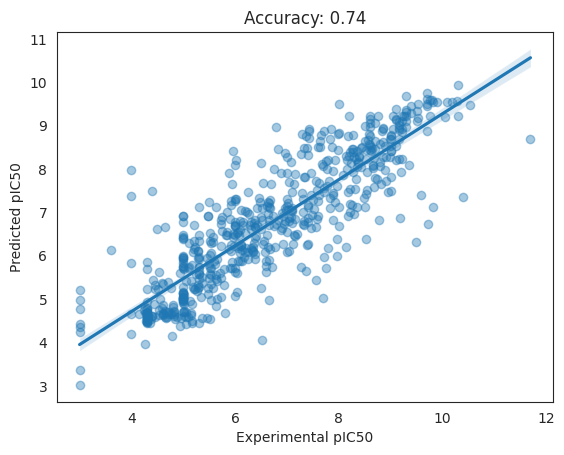

In [15]:
#sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50')
ax.set_title(f'Accuracy: {r2:.2f}')
ax.set_ylabel('Predicted pIC50')
plt.savefig('predicted_vs_experimental.tiff', dpi=300, bbox_inches='tight')
plt.show

In [9]:
import csv
def generate_csv_file(string1, string2, filename):
    data = [[string1 + '\t' + string2]]  # Create a list of lists containing the strings

    with open(filename, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerows(data)

string1 = 'Oc1ccc2c(c1)S[C@H](c1ccco1)[C@H](c1ccc(OCCN3CCCCC3)cc1)O2'
string2 = 'Compound_name'
filename = "molecule.smi"
generate_csv_file(string1, string2, filename)
#import glob to read xml file

padeldescriptor(mol_dir='molecule.smi', 
                d_file='descriptors.csv',
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                removesalt=True,
                fingerprints=True)
descriptors = pd.read_csv('descriptors.csv')
X = descriptors.drop('Name', axis=1)
model = joblib.load('padel_model.joblib')
y_pred = model.predict(X)
y_pred

array([7.25288979])

In [43]:
#import glob to read xml file
xml_files = glob.glob("fingerprints_xml/*.xml")
xml_files.sort()
FP_list = ['AtomPairs2DCount',  'AtomPairs2D', 'EState', 'CDKextended', 'CDK', 'CDKgraphonly', 'KlekotaRothCount',
 'KlekotaRoth', 'MACCS', 'PubChem', 'SubstructureCount', 'Substructure']
fp = dict(zip(FP_list, xml_files))
df = pd.read_csv('plasmodium_targets_final_pIC50.csv')
df2 = df[['canonical_smiles','pIC50']]
df2.to_csv('molecule.smi',sep='\t',index=False, header=False)
fingerprint = 'Substructure'
fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]

padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                removesalt=True,
                log=True,
                fingerprints=True)

descriptors = pd.read_csv(fingerprint_output_file)
descriptors = descriptors[np.isfinite(descriptors).all(1)].reset_index(drop=True)
np.shape(descriptors)

(3078, 308)